# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Load The Data

In [2]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

Basic information about data set such as total number of entries in training, validation and test sets or shape of single image or number of total classes can be seen as output from the following cell

In [4]:
import numpy as np

# Number of training examples
n_train = np.array(train['labels']).shape[0]

# Number of validation examples
n_validation = np.array(valid['labels']).shape[0]

# Number of testing examples.
n_test = np.array(test['labels']).shape[0]

# What's the shape of an traffic sign image?
image_shape = np.array(train['features'])[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(train['labels'])).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples: ", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples:  4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Dataset visualization

As output of following cell we can see single image from training set.

Label for given image:  25


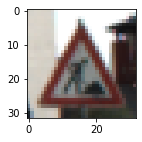

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

i = np.random.randint(0, len(X_train))
image = X_train[i].squeeze()

plt.figure(figsize = (2,2))
plt.imshow(image)
print("Label for given image: ", y_train[i])

In order to visualize occurance of all clases within different parts of data sets, we will first create histograms for each part of data set (train, validation and test). We shall place classes labels on x-axis and total number of occurances on y-axis. 

Histograms for each part of dataset can be seen as output of following cell.

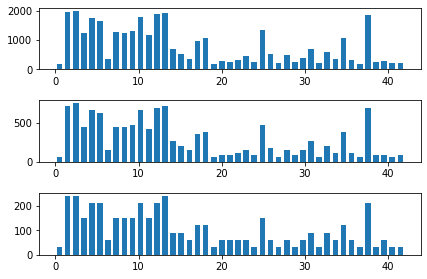

In [6]:
# Create graph showing occurance of each label
hist_train, bins = np.histogram(y_train, bins = n_classes)
hist_test, bins = np.histogram(y_test, bins = n_classes)
hist_valid, bins = np.histogram(y_valid, bins = n_classes)

fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad = 1)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
axs[0].bar(center, hist_train, align='center', width=width)                           
axs[1].bar(center, hist_test, align='center', width=width)
axs[2].bar(center, hist_valid, align='center', width=width)
plt.show()

On image above we can see histogram of each part of the data set (Train, Test and Validation subsets respectively). From given histograms we can conclude that dataset is not balanced, since there is no equal number of appearances for each label. This could prove to be one factor which reduces prediction accuracy for  traffic signs that appear less frequently.

In addition to this, there is quite big ammount of occurances for speed limit signs, stop signs, yield signs, so it is safe to assume that after training our model will do better job in predicting these signs than signs like 'Dangerous curve to the left (label 19)'

----

## Design and Test a Model Architecture

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. 

Minimal amount of adaptation is needed for LeNet-5 architecture to be used as traffic sign classifier. Initial adaptations were changing input layer of network, to be able to handle 32x32x3 data instead of 32x32x1 as it was the case for digit classifier. In addition to this, output layer is also changed. Total number of outputs equals to number of classes, in our case 43. So fully connected output layer size was changed from 10 to 43. 

With the LeNet-5 solution from the lecture, i was able to achieve a validation set accuracy of about 0.89.

Further improvements of initial architecture were introducing drop-out at fully connected layers. This improveded training and validation accuracy by decent amount and prevented overfitting.

Another improvement that helped me to increase validation and training accuracy is input data normalization, which was helpful for tensorflow optimizers and it resulted in better results.

Final tweak of initial acrhitecture was adding additional convolution layer. After this additional layer, it's output is combined with output from previous convolution layer, where each output is flattened to 1x1xN size and then these outputs are combined (concatenated). Prior to introducing this improvement architecture seemed like it experienced slight underfitting. This helped with network underfitting and eventually improved prediction accuracy. Inception module along with [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) served as inspiration for this improvement.

### Pre-process the Data Set (normalization, grayscale, etc.)

Normalization is only form of data preprocessing used in this project. With normlaization we make mean value of image small number, close to zero, and equal variance. 

I have choosen not to convert image to grayscale, since color of the traffic sign could prove to bee valuable information when we try to clasify them.

In [7]:
### Preprocess the data here. It is required to normalize the data.

# We want to normalize input so we have 0 mean
def normalize(input):
    normalized = np.array((input - 128.0) / 128.0)
    return normalized


In [8]:
from sklearn.utils import shuffle

# Intially shuffle training set
X_train, y_train = shuffle(X_train, y_train)

print("Mean of image before normalization: ", np.mean(X_train[0]))
print("Variance of image before normalization: ", np.var(X_train[0]))

# Normalize data set
X_train_normalized = normalize(X_train)
X_test_normalized = normalize(X_test)
X_valid_normalized = normalize(X_valid)

print("Mean of image after normalization: ", np.mean(X_train_normalized[0]))
print("Variance of image after normalization: ", np.var(X_train_normalized[0]))


Mean of image before normalization:  36.351888020833336
Variance of image before normalization:  359.27884409162726
Mean of image after normalization:  -0.7160008748372396
Variance of image after normalization:  0.02192864038645186


### Model Architecture

In [9]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.contrib.layers import flatten

EPOCHS = 20
BATCH_SIZE = 128

In [10]:
# Create weights and biases for NN
# Parameters for initial random values for weights
mu = 0 # mean
sigma = 0.1 # deviation

weights = {
    'conv_w1' : tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 6), mean = mu, stddev = sigma)),
    'conv_w2' : tf.Variable(tf.truncated_normal(shape = (5, 5, 6, 16), mean = mu, stddev = sigma)),
    'conv_w3' : tf.Variable(tf.truncated_normal(shape = (3, 3, 16, 32), mean = mu, stddev = sigma)),
    'fc_w1' : tf.Variable(tf.truncated_normal(shape = (688, 120), mean = mu, stddev = sigma)),
    'fc_w2' : tf.Variable(tf.truncated_normal(shape = (120, 84), mean = mu, stddev = sigma)),
    'fc_w3' : tf.Variable(tf.truncated_normal(shape = (84, 43), mean = mu, stddev = sigma))
}
biases = {
    'conv_b1' : tf.Variable(tf.zeros(6)),
    'conv_b2' : tf.Variable(tf.zeros(16)),
    'conv_b3' : tf.Variable(tf.zeros(32)),
    'fc_b1' : tf.Variable(tf.zeros(120)),
    'fc_b2' : tf.Variable(tf.zeros(84)),
    'fc_b3' : tf.Variable(tf.zeros(43))
}

In [11]:
# Function for nn inference
def le_tsc_net(input, weights, biases, dropout):
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6. 
    conv_1 = tf.nn.bias_add(tf.nn.conv2d(x, weights['conv_w1'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv_b1'])

    # Activation.
    conv_1_activation = tf.nn.relu(conv_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    max_pooling1 = tf.nn.max_pool(conv_1_activation, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv_2 = tf.nn.bias_add(tf.nn.conv2d(max_pooling1, weights['conv_w2'], strides=[1, 1, 1, 1], padding='VALID'), biases['conv_b2'])
    
    # Activation.
    conv_2_activation = tf.nn.relu(conv_2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    max_pooling2 = tf.nn.max_pool(conv_2_activation, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')

    # Layer 3: Convolution. Input 5x5x16. Output = 3x3x32
    conv_3 = tf.nn.bias_add(tf.nn.conv2d(max_pooling2, weights['conv_w3'], strides=[1, 1, 1, 1], padding = 'VALID'), biases['conv_b3'])

    # Activation.
    conv_3_activation = tf.nn.relu(conv_3)

    # Flatten. Input = 5x5x16. Output = 400.
    flattened_conv2 = tf.contrib.layers.flatten(max_pooling2)

    # Flatten. Input = 3x3x32. Output = 288.
    flattened_conv3 = tf.contrib.layers.flatten(conv_3_activation)

    # Concatenated output. Output = 688
    concated_convs = tf.concat([flattened_conv2, flattened_conv3], 1)
    
    # Layer 3: Fully Connected. Input = 688. Output = 120.
    fc1 = tf.add(tf.matmul(concated_convs, weights['fc_w1']), biases['fc_b1'])
    
    # Activation.
    fc1_activation = tf.nn.relu(fc1)
    fc1_activation = tf.nn.dropout(fc1_activation, dropout)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1_activation, weights['fc_w2']), biases['fc_b2'])
    
    # Activation.
    fc2_activation = tf.nn.relu(fc2)
    fc2_activation = tf.nn.dropout(fc2_activation, dropout)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2_activation,  weights['fc_w3']), biases['fc_b3'])
    
    return logits



In [12]:
total_classes = n_classes

# Define inputs
keep_prob = tf.placeholder(tf.float32)
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, total_classes)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Training operations
rate = 0.001

# Output of nn
logits = le_tsc_net(x, weights, biases, keep_prob)

# Cross entropy to determin error
cross_entropy_operation = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)

# Loss - mean of cross entropy
loss_operation = tf.reduce_mean(cross_entropy_operation)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Model Evaluation
Evaluate model loss and accuracy. Model accuracy is calculate by comparing logits to the training set labels for each input. After, these comparisons are averaged, and this represents models accuracy.

In [14]:
# Check for equality between nn prediciton and given labels
correct_prediciton = tf.equal(tf.arg_max(one_hot_y, 1), tf.arg_max(logits, 1))

# Calculate total accuracy as mean of vector with 0 (false predictions one_hot_y != logits) and 1 (true predictions)
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediciton, tf.float32))

# Saver - utilized for saving weights of current session
saver = tf.train.Saver()

Instructions for updating:
Use `argmax` instead


In [15]:
# Utility function for printing stats
# Check total accuracy for current weights on test
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Model training
- Run the model on training data
- Before each epoch shuffle set
- After each epoch evaluate current state of the model (Accuracy) on validation set
- Save the model after training

In [16]:
# Training the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_normalized)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # For each epoch shuffle train dataset
        X_train_normalized, y_train = shuffle(X_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train[offset:end]
            # Feed normalized train dataset
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.50})

        # For each epoch evaluate training and validation accuracy    
        training_accuracy = evaluate(X_train_normalized, y_train)
        validation_accuracy = evaluate(X_valid_normalized, y_valid)

        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.644
Validation Accuracy = 0.568

EPOCH 2 ...
Training Accuracy = 0.852
Validation Accuracy = 0.793

EPOCH 3 ...
Training Accuracy = 0.932
Validation Accuracy = 0.878

EPOCH 4 ...
Training Accuracy = 0.954
Validation Accuracy = 0.910

EPOCH 5 ...
Training Accuracy = 0.968
Validation Accuracy = 0.931

EPOCH 6 ...
Training Accuracy = 0.975
Validation Accuracy = 0.941

EPOCH 7 ...
Training Accuracy = 0.979
Validation Accuracy = 0.942

EPOCH 8 ...
Training Accuracy = 0.983
Validation Accuracy = 0.945

EPOCH 9 ...
Training Accuracy = 0.985
Validation Accuracy = 0.946

EPOCH 10 ...
Training Accuracy = 0.988
Validation Accuracy = 0.952

EPOCH 11 ...
Training Accuracy = 0.988
Validation Accuracy = 0.947

EPOCH 12 ...
Training Accuracy = 0.990
Validation Accuracy = 0.955

EPOCH 13 ...
Training Accuracy = 0.993
Validation Accuracy = 0.959

EPOCH 14 ...
Training Accuracy = 0.993
Validation Accuracy = 0.957

EPOCH 15 ...
Training Accuracy = 0.993
Valid

**Check point is here, from here we have model saved!**

In [17]:
# Check the test accuracy

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.944


Model's test accuracy is shown as output of above cell. Test accuracy is calculated when test part of data set is given as input to the model. Testing step is executed only once training phase has been finished.

---

## Test a Model on New Images

In order to achieve more insight into how my model is performing, I have found additional images of German traffic signs and cropped and rescaled them to the right size. They served as additional test for my model. It is important to note, that these images were not part of training or validation set. 

### Load and Output the Images

Afeter running cell bellow this one, additional test images are shown alongside appropriate labels.

Additional data mean:  -0.13495381673177084
Additional data var:  0.3110404415418291
Labels:  [25, 13, 18, 17, 1]


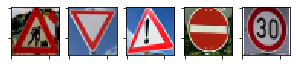

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import cv2
import glob

fig, axs = plt.subplots(1, 5, figsize = (5, 1))

# Turn off tick labels
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Load additional test images - Images are already scaled to 32x32x3
image_list = []
for filename in glob.glob('test-images/*.png'):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_list.append(image)

# Display images
i = 0
for image in image_list:
    axs[i].imshow(image)
    i = i + 1

# Create input data
X_test_additional = np.array(image_list)
Y_test_additional = [25, 13, 18, 17, 1]

# Preprocess additional test data
X_test_additional_normalized = normalize(X_test_additional)
print('Additional data mean: ', np.mean(X_test_additional_normalized))
print('Additional data var: ', np.var(X_test_additional_normalized))
print('Labels: ', Y_test_additional)

### Predict the Sign Type for Each Image and Analyze Performance

Once additional test data is loaded, we can check our model accuracy on data that was not used before ("Real world").

In [19]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    additional_test_saver = tf.train.import_meta_graph('./lenet.meta')
    additional_test_saver.restore(sess, "./lenet")
    additional_test_accuracy = evaluate(X_test_additional_normalized, Y_test_additional)
    print("Additional test accuracy = {:.3f}".format(additional_test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Additional test accuracy = 0.800


Here we can see that output accuracy of model is 80% which means that it predicted 4 out of 5 test images correctly. This accuracy is significantly lower than validation accuracy and this is the result of small number of inputs. In addition to this, traffic signs in additional test images are slightly rotated and different backgrounds could also play part in this wrongful predictions.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [20]:
# Read all the label names from sign names
sign_names_file = open("signnames.csv", "r")

# Skip 1st line
sign_names_file.readline()
lines = sign_names_file.read().split('\n')
# Discard last line
lines = lines[0:-1]

# Prepare list for with sign names
sign_names = []
for line in lines:
    sign_names.append(line.split(',')[1])

INFO:tensorflow:Restoring parameters from ./lenet


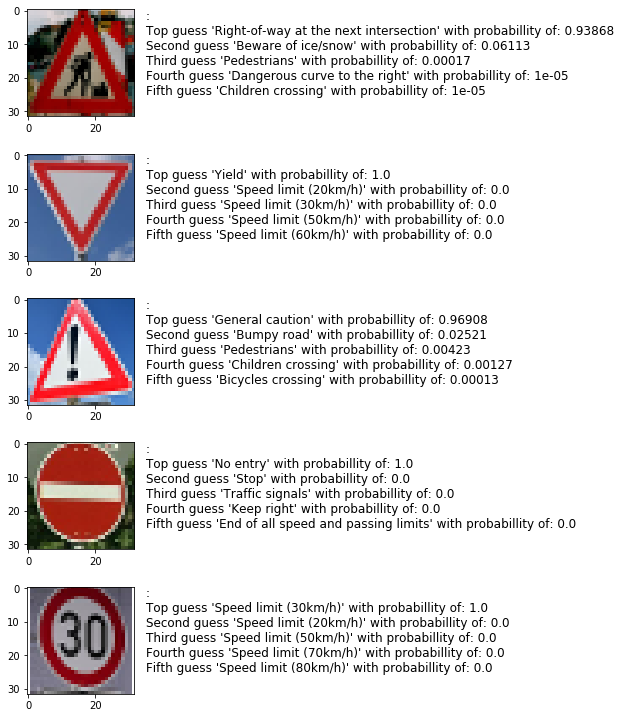

In [56]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# Find top k values from softmax
softmax_operation = tf.nn.softmax(logits)
top_k_operation = tf.nn.top_k(softmax_operation, k = 5)

with tf.Session() as sess:
    top_k_saver = tf.train.import_meta_graph('./lenet.meta')
    top_k_saver.restore(sess, "./lenet")
    # Acquire top 5 probabilities
    top_k = sess.run(top_k_operation, feed_dict={x: X_test_additional_normalized, keep_prob: 1.0})
    
    fig, ax = plt.subplots(5, 1, figsize = (10, 10))
    for i in range(5):
        ax[i].imshow(image_list[i])
        text = ":\nTop guess '" + sign_names[top_k.indices[i][0]] + "' with probabillity of: " + str(round(top_k.values[i][0], 5)) + \
                "\nSecond guess '" + sign_names[top_k.indices[i][1]] + "' with probabillity of: " + str(round(top_k.values[i][1], 5)) +\
                "\nThird guess '" + sign_names[top_k.indices[i][2]] + "' with probabillity of: " + str(round(top_k.values[i][2], 5)) + \
                "\nFourth guess '" + sign_names[top_k.indices[i][3]] + "' with probabillity of: " + str(round(top_k.values[i][3], 5)) + \
                "\nFifth guess '" + sign_names[top_k.indices[i][4]] + "' with probabillity of: " + str(round(top_k.values[i][4], 5))
        ax[i].text(35, 25, text, fontsize=12)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.savefig("output/additional_test_probs.png")        

Top 5 probabilities for each additional test images are shown in figure above. Here we can see text form of top pick labels. One wrong prediction is in case of 'Road Work' sign, but in given image we can see there is additional sign in the background and this may be a reasson for false prediction. 

It's important to note that model gave high probability for each prediction, and there was almost no uncertainty.